# Базовые тесты

In [1]:
import TechCore.Simulator.simulator_optimized as simulator
import TechCore.Strategies.Stoikov as Stoikov
import TechCore.Simulator.get_info as get_info
import TechCore.Simulator.load_data as load_data

from importlib import reload

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

path_to_file = '../TechCore/data/md/btcusdt_Binance_LinearPerpetual/'
run_time = pd.Timedelta(10, 'm').delta

In [2]:
reload(simulator)
reload(Stoikov)
reload(get_info)
reload(load_data)

<module 'TechCore.Simulator.load_data' from 'C:\\Users\\artem\\.Computer Science\\CMF\\Projects\\High_Frequency_Market_Making\\TechCore\\Simulator\\load_data.py'>

In [3]:
md = load_data.load_md_from_file(path=path_to_file, run_time=run_time)

In [4]:
latency = pd.Timedelta(10, 'ms').delta
md_latency = pd.Timedelta(10, 'ms').delta

sim = simulator.SimOptim(md, latency, md_latency)

In [5]:
#delay between orders
delay = pd.Timedelta(0.1, 's').delta

strategy = Stoikov.Strategy(
    delay=delay,
    risk_koef=0.1,
    time_oi=60*10**9,
    avg_sum_oi=800,
    avg_time_oi=57471412238,
    order_fees=0.00001,
    avg_volatility=25,
    min_asset_value=0.001,
    volatility_record_cooldown=0.1*10**9, #ns
    volatility_horizon=1000,
    order_intensity_min_samples=100
)
# вся эта история с avg нужна для того, чтобы order_intensity и volatility были равны 1 в среднем.

In [6]:
trades_list, md_list, updates_list, all_orders = strategy.run(sim)

In [7]:
df = get_info.get_pnl(updates_list)

In [8]:
dt = pd.to_datetime(df.receive_ts)

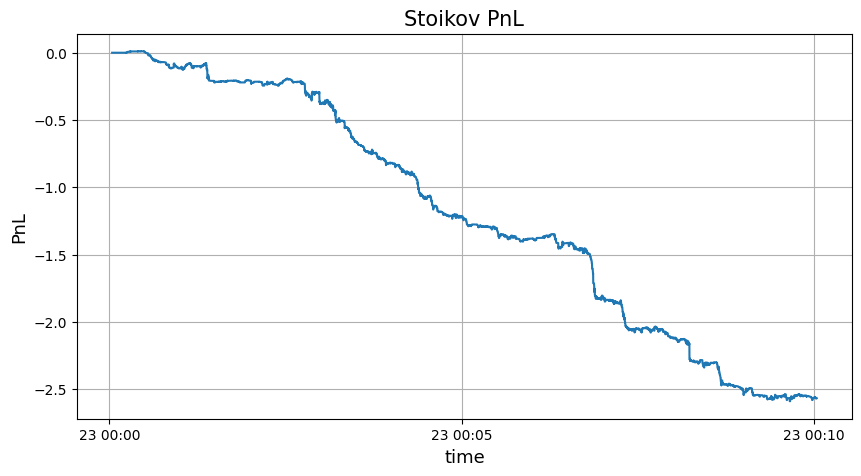

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(dt, df.total, '-')
plt.xlabel("time", fontsize=13)
plt.ylabel("PnL", fontsize=13)
plt.title("Stoikov PnL", fontsize=15)
plt.grid()
plt.show()

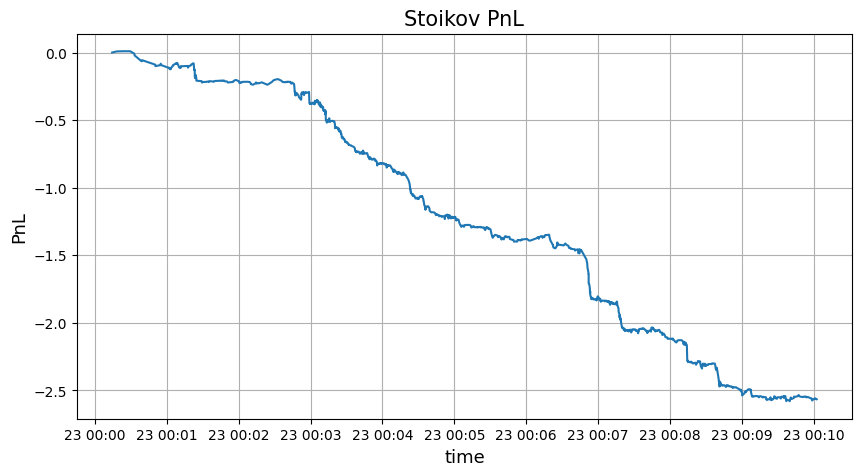

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(pd.to_datetime(strategy.logs['own_trade_time']), strategy.logs['pnl_with_liq'], '-')
plt.xlabel("time", fontsize=13)
plt.ylabel("PnL", fontsize=13)
plt.title("Stoikov PnL", fontsize=15)
plt.grid()
plt.show()

In [11]:
logs = strategy.logs

In [12]:
own_trade_group = [
    'asset_position',
    'usd_position',
    'total_liq',
    'pnl',
    'pnl_with_liq',
]
own_trade_time = 'own_trade_time'

In [13]:
place_order_group = [
    'best_ask',
    'best_bid',
    'midprice',
    'stock_spread',
    'ask_place',
    'bid_place',
    'indiff_price',
    'my_spread',
    'ask_diff',
    'bid_diff',
    'order_intensity',
    'volatility',
    'oi_window_size',
    'place_order_time'
]

place_order_time = 'place_order_time'

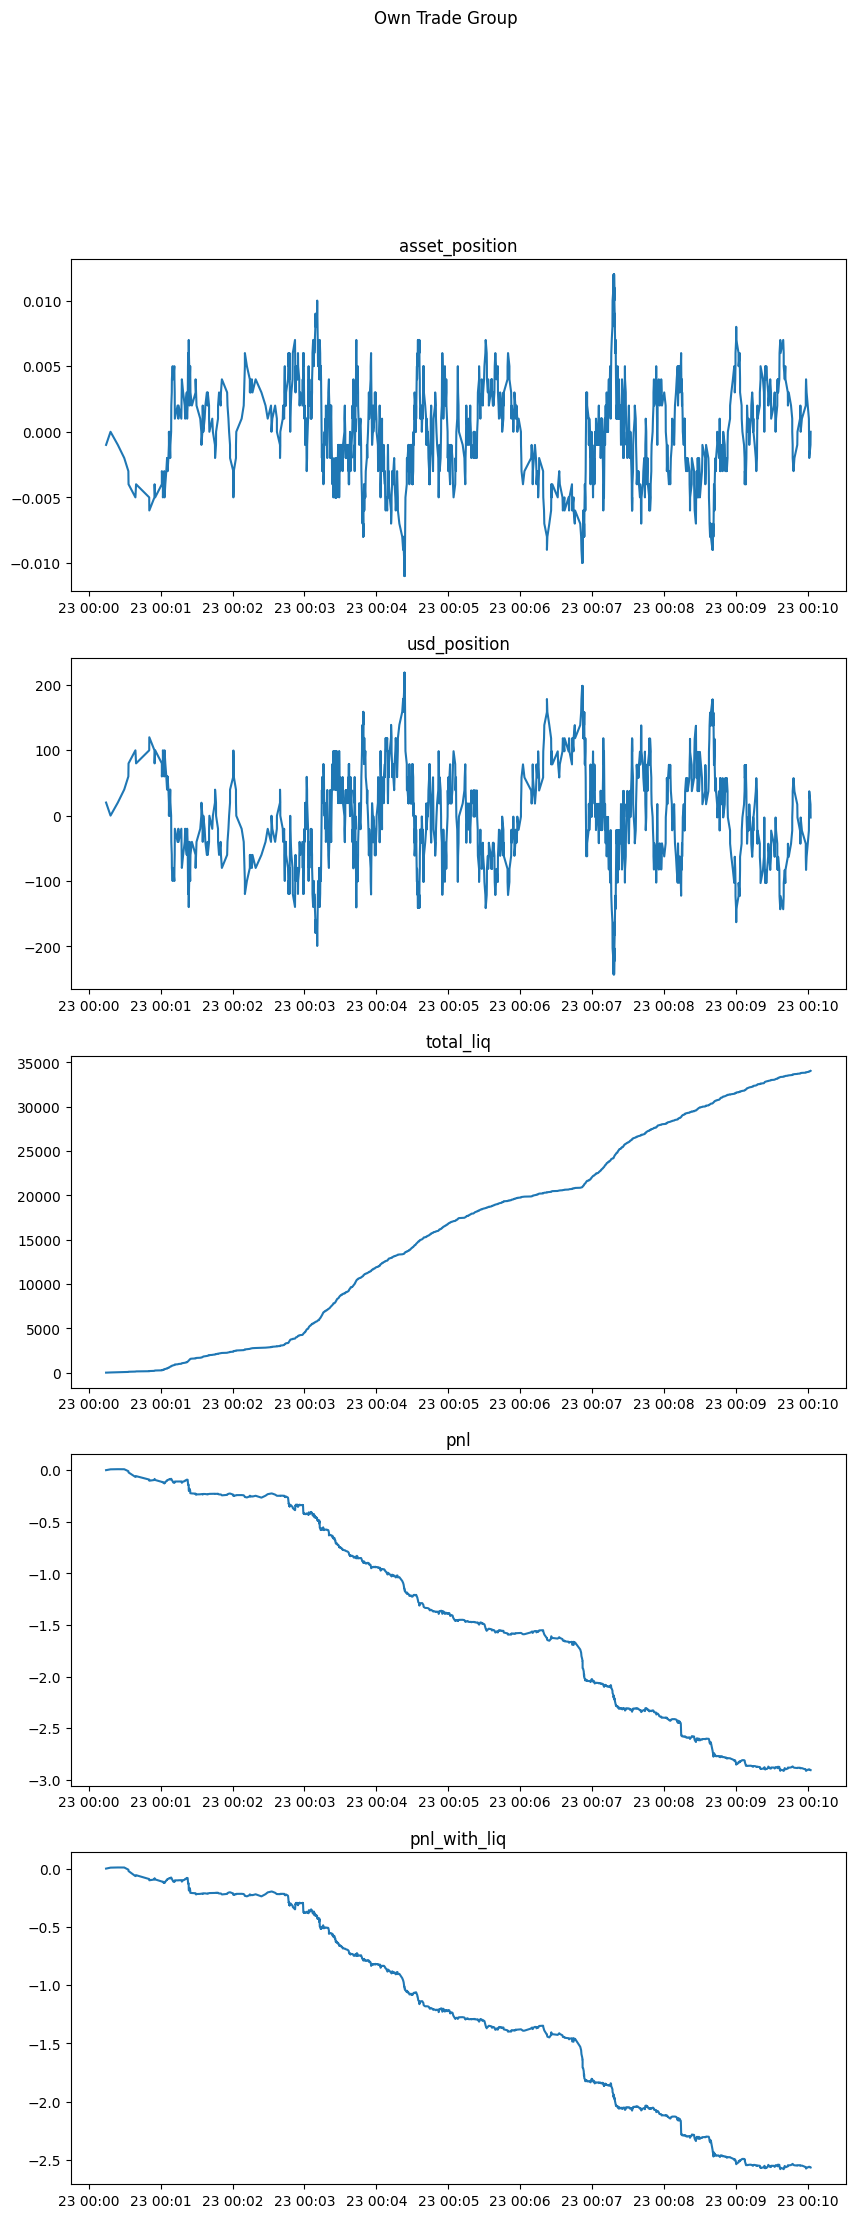

In [14]:
fig, axs = plt.subplots(len(own_trade_group), figsize=(10, 5*len(own_trade_group)))
fig.suptitle('Own Trade Group')

ind = 0
for i in own_trade_group:
    axs[ind].plot(pd.to_datetime(logs[own_trade_time]), logs[i])
    axs[ind].set_title(i)
    ind += 1

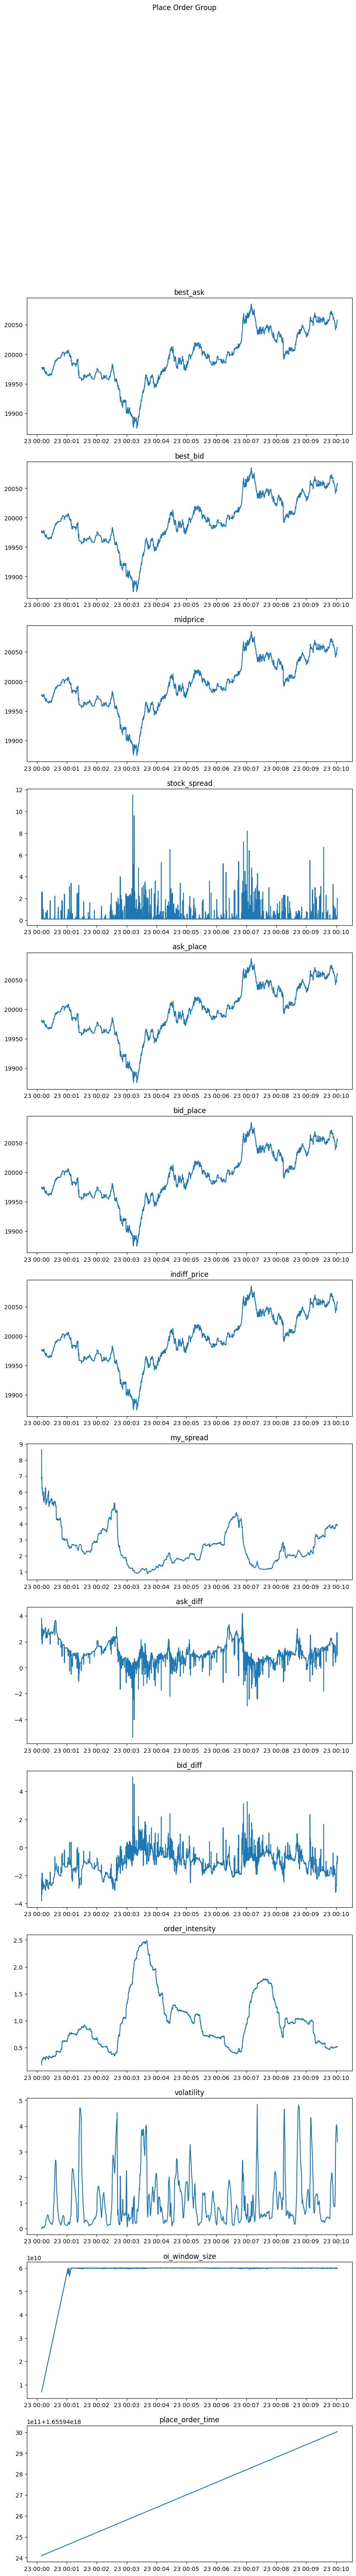

In [15]:
fig, axs = plt.subplots(len(place_order_group), figsize=(10, 5*len(place_order_group)))
fig.suptitle('Place Order Group')

ind = 0
for i in place_order_group:
    try:
        axs[ind].plot(pd.to_datetime(logs[place_order_time]), logs[i])
        axs[ind].set_title(i)
        ind += 1
    except:
        pass

# Подбор risk_koef (gamma)

In [16]:
def run_stoikov(gamma):
    reload(simulator)
    reload(Stoikov)
    reload(get_info)
    reload(load_data)
    run_time = pd.Timedelta(10, 'm').delta
    md = load_data.load_md_from_file(path=path_to_file, run_time=run_time)
    latency = pd.Timedelta(10, 'ms').delta
    md_latency = pd.Timedelta(10, 'ms').delta

    sim = simulator.SimOptim(md, latency, md_latency)

    #delay between orders
    delay = pd.Timedelta(0.1, 's').delta

    strat = Stoikov.Strategy(
        delay=delay,
        risk_koef=gamma,
        time_oi=60*10**9,
        avg_sum_oi=800,
        avg_time_oi=57471412238,
        order_fees=0.00001,
        avg_volatility=25,
        min_asset_value=0.001,
        volatility_record_cooldown=0.1*10**9, #ns
        volatility_horizon=1000,
        order_intensity_min_samples=100
    )
    strat.run(sim)
    return strat.logs

In [17]:
gamma_list = [0.0001, 0.001, 0.01, 0.1, 1]
logs_list = []
for gamma in gamma_list:
    logs_list.append(run_stoikov(gamma))

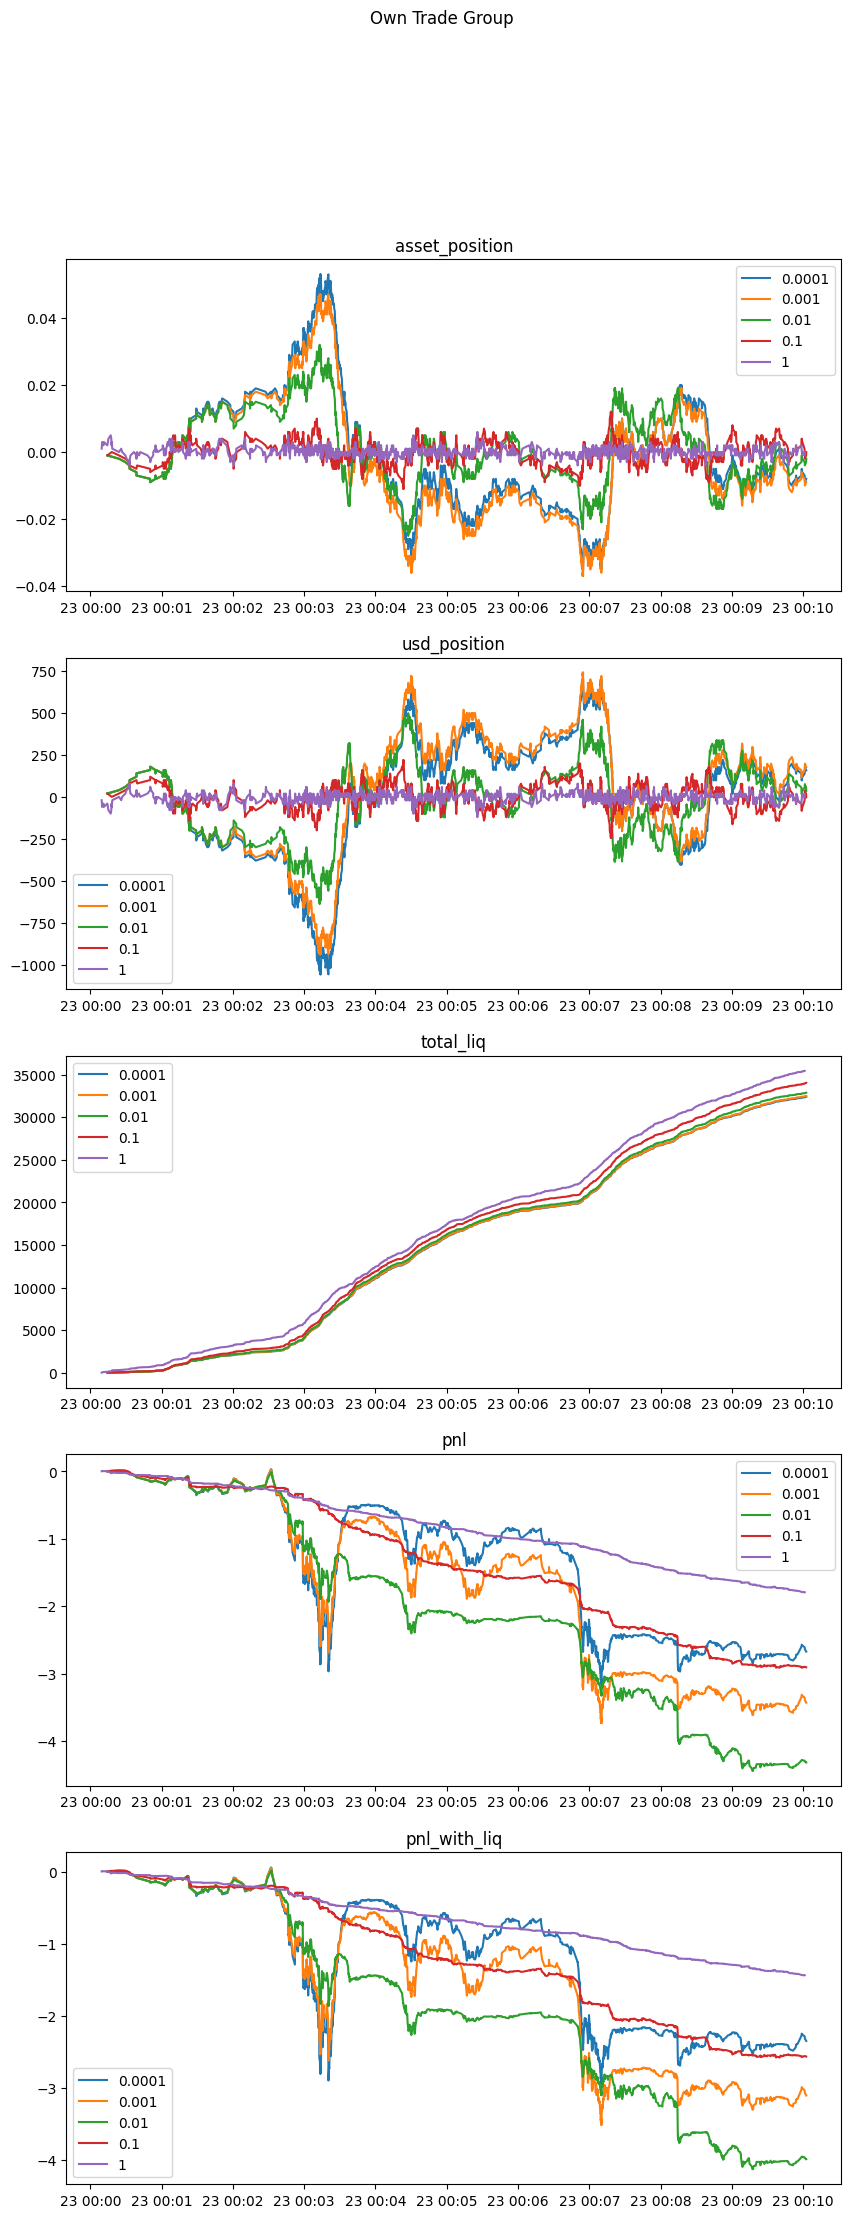

In [18]:
fig, axs = plt.subplots(len(own_trade_group), figsize=(10, 5*len(own_trade_group)))
fig.suptitle('Own Trade Group')

ind = 0
for i in own_trade_group:
    for gamma, logs in zip(gamma_list, logs_list):
        axs[ind].plot(pd.to_datetime(logs[own_trade_time]), logs[i], label=gamma)
    axs[ind].set_title(i)
    axs[ind].legend()
    ind += 1

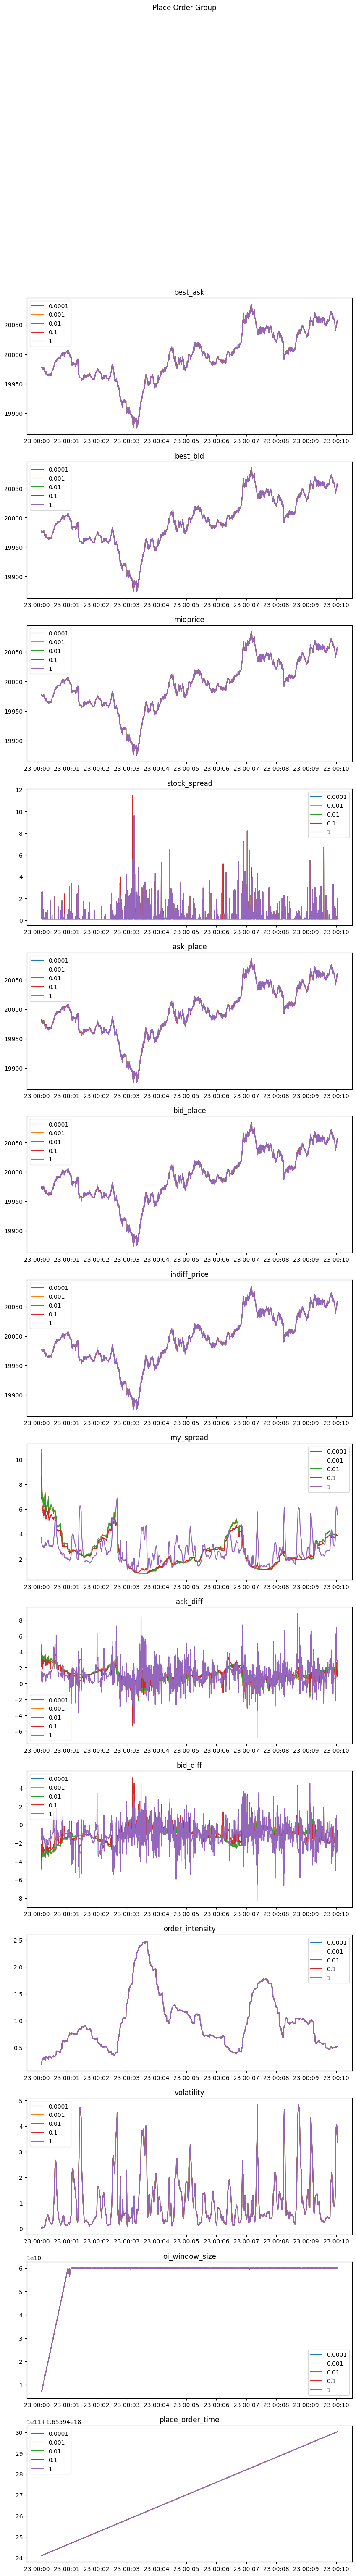

In [19]:
fig, axs = plt.subplots(len(place_order_group), figsize=(10, 5*len(place_order_group)))
fig.suptitle('Place Order Group')

ind = 0
for i in place_order_group:
    for gamma, logs in zip(gamma_list, logs_list):
        axs[ind].plot(pd.to_datetime(logs[place_order_time]), logs[i], label=gamma)
    axs[ind].set_title(i)
    axs[ind].legend()
    ind += 1

В целом - все гипотезы (про gamma) подтвердились. Мне кажется что это если не идеально, то около того :)